# Student: Marco Antonio Manzo Ruiz 
# ID: 173127
# Project 2: GAN to generate faces
#Date: 04/02/2023


# Time String to be used to count different things, for example, the time that epochs take, or the time that an image takes to be processed.

In [1]:
def Time_Function(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import time
import tensorflow_datasets as tfds
import zipfile
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Code to connect Google Drive with Google Colab. If the connection fails or the path is wrong, an exception will be raised.

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Google CoLab connection SUCCESSFUL.")
    # The next line works if someone wants to run the code in another place different than Google Colab.
    %tensorflow_version 2.x
except:
    print("Google CoLab connection FAILED.")
    COLAB = False

Mounted at /content/drive
Google CoLab connection SUCCESSFUL.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Set up variables for the training and the images, for example, the number of Epochs or how the Image will be previewed.


In [5]:
# Resolution factor 
GENERATE_RES = 3 
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Preview the image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 150

# Configuration: Set up the training and select the number of epochs. 
DATA_PATH = '/content/drive/MyDrive/GANPROYECT'
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


# The next code block is need to unzip the folder in Google Drive. By doing this, I avoid overloading the Google Drive memory capacity, for I only upload a .zip file there and manage the photos in the local computer.

In [6]:
import os
# unzip the data
def unzip(path):
  from zipfile import ZipFile
  
  with ZipFile(path, "r") as z:
    # extrac all
    z.extractall()

unzip("/content/drive/MyDrive/GANPROYECT/PhotosDataSet.zip")

# Save a binary file in order to avoid losing progress. A binary file has an extension ".h5" and can store large amount of data, in this case, large amount of photos. It also loads the training images for the Generation of Faces.


In [7]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"File: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading images...")

  training_data = []
  faces_zip_path = '/content/drive/MyDrive/GANPROYECT/PhotosDataSet.zip'
  with zipfile.ZipFile(faces_zip_path, 'r') as zip_file:
        for filename in tqdm(zip_file.namelist()):
            with zip_file.open(filename) as image_file:
                image = Image.open(image_file).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)
                training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary file")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {Time_Function(elapsed)}')
else:
  training_data = np.load(training_binary_path)

File: /content/drive/MyDrive/GANPROYECT/training_data_96_96.npy


# This code creates a TensorFlow dataset from the training data, it also prepares the data to be used in training. It uses the variables from the beginning  to see the buffer and the batch size.

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# The next block creates or builds the generator and the discriminator.

In [9]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# The next block of code saves the images in a file in Google Drive. The file can be changed by changing the string in the "output_path" variable.

In [10]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output-with-10Epochs-10kImages')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

# This block creates the generator. It uses the seed size and the image channels as parameters in the build_generator function, in this case, a seed size of 150 appeared to be best to generate better images. With a smaller size, the images looked to similar with each other, when it was bigger, the images lost quality and the training sometimes crashed.

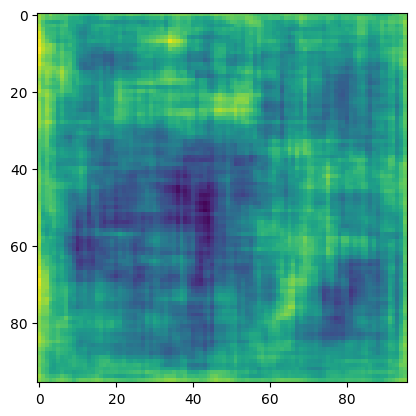

In [11]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

# This next block creates the discriminator which chooses if an image created by the generator is real or fake and stores it in the "decision" variable.

In [12]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5004372]], shape=(1, 1), dtype=float32)


#These two functions calculate the loss of the discriminator and the generator. The discriminator loss will be between 0 and 1. While the generator loss will be between 0 and infinity.

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# This next two lines of code use an optimizer class from TensorFlow Keras API. These two lines make the epochs run in less than 10 seconds each no matter the number of images. There was only an increase in time of one second when the sample photos went from 6000 to 10000 photos.

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# This next function defines a single training step for the GAN model. It takes a batch of real images as input, generates a batch of fake images with the generator, and then computes the losses and gradients for both the generator and discriminator models.

In [15]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

#This function defines the training loop for the GAN. It takes in a dataset and the number of epochs to train for.

In [16]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {Time_Function(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {Time_Function(elapsed)}')

#This next line begins the training process.

In [17]:
train(train_dataset, EPOCHS)

KeyboardInterrupt: ignored

# The next line of code saves the generator model to the path in the string. The file is saved in Google Drive.

In [ ]:
generator.save(os.path.join(DATA_PATH,"10Epochs-10kImages"))

#This code generates a grid of preview images using the trained generator model.

1/1 [==============================] - 0s 20ms/step


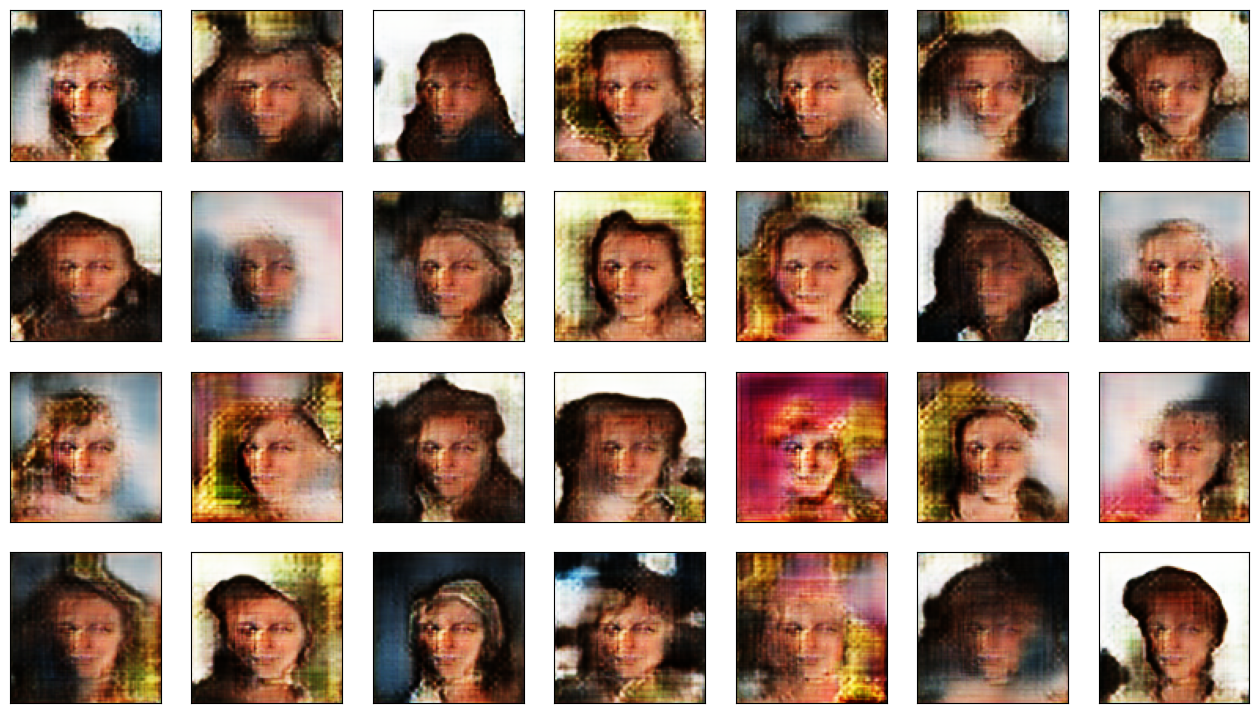

In [ ]:
noise = tf.random.normal([PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE])
generated_images = generator.predict(noise)

generated_images = 0.5 * generated_images + 0.5 

fig, axes = plt.subplots(PREVIEW_ROWS, PREVIEW_COLS, figsize=(16, 9),
                          subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i])
    
plt.show()